<a href="https://colab.research.google.com/github/Baldros/NLP-Course-HuggingFace/blob/main/3.3.%20Full_traning(Fine_Tuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação:

    Passado por cada etapa do treinamento de um modelo, a ideia aqui
    e reconstruir o processo de treinamento do modelo de ponta ponta.

    É interessante aqui que se utilizer a GPU para treinamento do modelo,
    devido o seu melhor desempenho com relação a CPU. O google colab possibilita
    essa troca na parte de ambiente de execução, é possivel alterar o tipo,
    o que será bem útil, então se for rodar em GPU, tenha certeza de estar
    rodando o código em GPU de preferência desde agora.

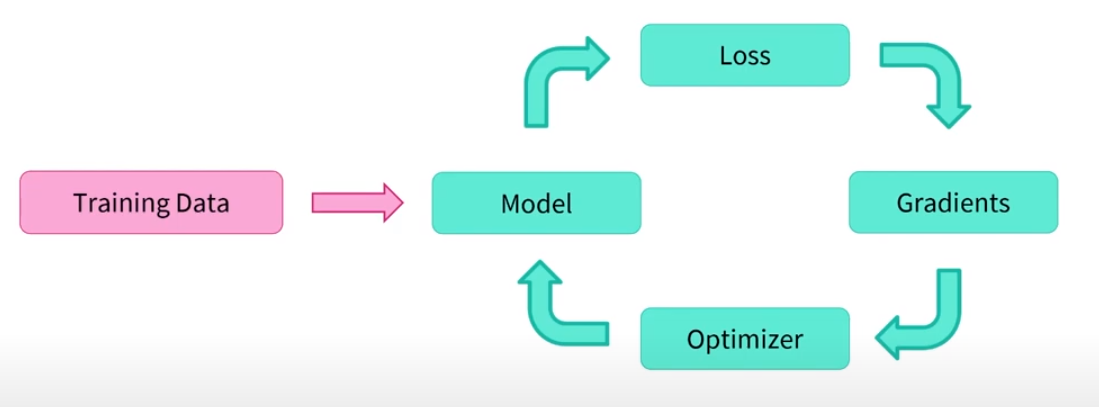

Nota:

    Aqui, todo o topico é abordado apenas em Pytorch, o que é um tanto
    curioso.

In [ ]:
# Instalando o biblioteca de datasets do HF:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00


# Pré-processamento dos dados:

    Agora veremos como alcançar os mesmos resultados que obtivemos
    na última seção sem usar a classe Trainer. Novamente, presume-se
    que se tenha feito o processamento de dados na seção 2. Aqui
    está um breve resumo cobrindo tudo o que você precisará:

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

# Preparando o treinamento:

    A ideia aqui é executar o treinamento sem utilizar a Classes Trainer da
    biblioteca transformers, deste modo, muita das facilidades que a biblioteca
    nos faz, aqui não poderam ser utilizadas. Deste modo, precisaremos definir
    alguns objetos. O primeiro são os carregadores de dados que usaremos para
    iterar sobre lotes (batchs). Mas antes de podermos definir esses
    carregadores de dados, precisamos aplicar um pouco de pós-processamento
    aos nossos tokenized_datasets, para lidar com algumas coisas que o
    Trainer fez automaticamente para nós. Especificamente, precisamos:

    1. Remover as colunas correspondentes a valores que o modelo não
    espera (como as colunas sentence1 e sentence2).

    2. Renomear a coluna label para labels (porque o modelo espera que
    o argumento seja chamado labels).

    3. Definir o formato dos conjuntos de dados para que eles retornem
    tensores do PyTorch em vez de listas.

    Nosso tokenized_datasets possui um método para cada um desses passos:

In [ ]:
# Remover as colunas que não uteis para o modelo:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])

# Renomerando colunas para que o modelo entenda:
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Definindo o formato do conjunto de dados:
tokenized_datasets.set_format("torch")

# Pegando os labels dos dados de treindo
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

**Definindo os Dataloaders**

    Agora que isso foi feito, podemos facilmente definir nossos
    carregadores de dados (dataloaders):

In [ ]:
# Importando a Classe de Carregamento de Dados:
from torch.utils.data import DataLoader

# Separando os dados de Treino:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)

# Separando os dados de Validação:
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

    Podemos verificar rapidamente se não há erro no processamento dos
    dados, podemos inspecionar um lote (batch) da seguinte forma:

In [ ]:
# Extraindo os batchs:
for batch in train_dataloader:
    break # É uma forma curiosa de extração dos Batchs:

# Visualizando o tamanho das matrizes de cada key:
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 69]),
 'token_type_ids': torch.Size([8, 69]),
 'attention_mask': torch.Size([8, 69])}

**Nota**

    Quando instânciamos o DataLoader dos dados de treino, definimos o parametro
    de embaralhamento como True (shuffle=True), deste modo, o exemplo aqui pode
    a saida acima provavelmente é diferente da do curso.

    Agora que terminamos completamente o pré-processamento dos dados (um
    objetivo satisfatório, mas elusivo para qualquer praticante de ML),
    vamos nos voltar para o modelo. Nós o instanciamos exatamente como
    fizemos na seção anterior:








In [ ]:
# Importando AutoMOdel para Classificação de Sentença:
from transformers import AutoModelForSequenceClassification

# Instanciando modelo:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    Para garantir que tudo corra bem durante o treinamento,
    passamos nosso lote para este modelo:

In [ ]:
# Saida do modelo:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.5127, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


In [ ]:
# Visualizando o Output:
outputs

SequenceClassifierOutput(loss=tensor(0.5127, grad_fn=<NllLossBackward0>), logits=tensor([[-0.2145,  0.3995],
        [-0.2241,  0.3924],
        [-0.2250,  0.3614],
        [-0.2308,  0.3075],
        [-0.2360,  0.3874],
        [-0.2288,  0.3936],
        [-0.2275,  0.4029],
        [-0.2136,  0.4161]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

**Nota**

    Note que essas saidas não são as saídas finais do modelo,
    tendo e vista que não passaram pela função de ativação da
    ultima camada. Ou seja, não passaram pela cabeça, o que é
    óbvio, porque a cabeça nem foi treinada ainda. Estou pontuando
    para a nomenclatura "output" não induzir ao erro.

In [ ]:
# Importando Otimizador:
from transformers import AdamW

# Instanciando Optimizador:
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


    Finalmente, o agendador de taxa de aprendizado usado por padrão é
    apenas um decaimento linear do valor máximo (5e-5) para 0. Para defini-lo
    corretamente, precisamos saber o número de etapas de treinamento que
    faremos, que é o número de épocas que queremos executar multiplicado
    pelo número de lotes de treinamento (que é o comprimento do nosso
    carregador de dados de treinamento). O Trainer usa três épocas por
    padrão, então vamos seguir isso:

In [ ]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1377


# O loop de Treinamento:

    Aqui, o ideal é utilizarmos uma GPU. O Google colab possui uma opção de
    GPU para se utilizar de forma gratuitamente. É limitada, mas já nos ajuda
    nesse caso, caso não se tenha uma GPU acessivel no momento.



In [ ]:
# Importando pytorch:
import torch

# Instanciando device:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Mudano para GPU:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Checando device:
torch.device(type='cuda')

device(type='cuda')

    Feito toda essa preparação, estamos ápitos a começar
    o treinamento (fine-tuning) do noddo modelo.

In [ ]:
# Importação para avaliar a progressão:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

# Treinando o modelo:
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1377 [00:00<?, ?it/s]

    Podemos ver que o núcleo do loop de treinamento se parece muito com o
    da introdução. Não pedimos nenhum relatório, então este loop de treinamento
    não nos dirá nada sobre como o modelo está se saindo. Precisamos adicionar
    um loop de avaliação para isso.

# O loop de avaliação:

    Como fizemos anteriormente, usaremos uma métrica fornecida pela
    biblioteca 🤗 Evaluate. Já vimos o método metric.compute(), mas
    as métricas na verdade podem acumular lotes para nós enquanto
    passamos pelo loop de previsão com o método add_batch(). Uma vez
    que acumulamos todos os lotes, podemos obter o resultado final
    com metric.compute(). Aqui está como implementar tudo isso em
    um loop de avaliação:

In [ ]:
# Instalando biblioteca de avaliação do treinamento:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
# Importando Classe de avaliação:
import evaluate # Note que é outro modelo

# Instanciando a Classe
metric = evaluate.load("glue", "mrpc")

# Iniciando modo de avaliação:
model.eval()

# Itera sobre os lotes de dados fornecidos pelo DataLoader de avaliação
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()} # Move os dados do lote para o dispositivo especificado (CPU ou GPU)

    with torch.no_grad(): # Desabilita o rastreamento do autograd para otimizar a memória durante a avaliação
        outputs = model(**batch) # Passa o lote de dados para o modelo e obtém as saídas do modelo

    logits = outputs.logits # Extrai os logits (saídas antes da aplicação de softmax) das saídas do modelo
    predictions = torch.argmax(logits, dim=-1) # Calcula o índice da classe prevista para cada exemplo no lote
    metric.add_batch(predictions=predictions, references=batch["labels"]) # Adiciona o lote de previsões e os rótulos de referência ao objeto de métrica

# Calculando as métricas:
metric.compute()

{'accuracy': 0.8725490196078431, 'f1': 0.9084507042253521}

**Acurácia**

    A acurácia é o método mais comum de se avaliar uma classificação,
    basicamente é uma razão acertos e possibilidades.

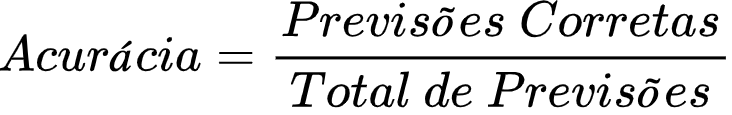

    O problema de utilizar essa forma simples de acurácia, é que ela não
    acomoda bem a incerteza da predição do modelo. A classificação pode
    gerar uns falsos positivos, tanto para classificações positivas, quanto
    para classificações negativas, que uma outra métrica acaba se fazendo
    necessária para esses casos. Provavelmente isso é o que justifica ter
    também a métrica F1 Score.

**F1 Score**

    O F1 Score já é uma métrica mais robusta, que leva em consideração
    essa incerteza referênte ao processo de classificação em seus calculos.

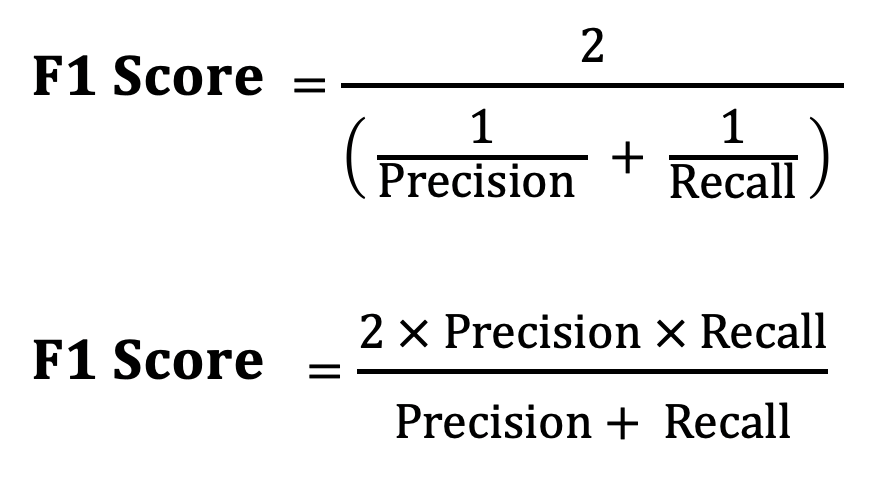

    Precisão e Recall também são métricas complementáres utilizadas em situação
    de classificação que complementam a informação de acuáracia, ou seja, a
    F1 Score é uma métrica que é construida de outras métricas, sendo assim
    uma métrica de fato mais robusta.

# Potencializando o loop de treinamento com 🤗 Accelerate.

    Para fechar a parte de treinamento do modelo, vamos ver
    Accelerate que  é uma API que melhora o tempo de treinamento.







**Treinamento sem o Accelerate**


In [ ]:
# Impostando Classes de otimização, modelo e escalonamento de taxa de aprendizado:
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

# Instanciado Modelo:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Instanciando otimizador:
optimizer = AdamW(model.parameters(), lr=3e-5)

# Instanciando Classe device para alterar de CPU para GPU:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device) # Mudando modelo para GPU

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

# Treinamento do modelo:
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1377 [00:00<?, ?it/s]

**Com Accelerate**

In [ ]:
# Instalando Biblioteca:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

accelerator = Accelerator()

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

num_epochs = 3
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dl:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1377 [00:00<?, ?it/s]